In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import sys, distutils.core
sys.path.insert(0, os.path.abspath('../detectron2'))
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../projects/Panoptic-DeepLab/'))
os.environ['DETECTRON2_DATASETS'] = '/home/liwa/data/datasets/'

from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config

from prediction import Predictor
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer

torch.set_num_threads(2)

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8700m"
cfg = get_cfg()
add_panoptic_deeplab_config(cfg)
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/liwa/data/oneformer_output/output/config.yaml")

cfg.MODEL.DEVICE = "cuda"
# into cpu model
# cfg.MODEL.SEM_SEG_HEAD.NORM = "BN"
# cfg.MODEL.INS_EMBED_HEAD.NORM = "BN"
# cfg.MODEL.RESNETS.NORM = "BN"

cfg.MODEL.PANOPTIC_DEEPLAB.TOP_K_INSTANCE = None
cfg.MODEL.PANOPTIC_DEEPLAB.INSTANCE_AREA_THRESHOLD = 3000

# cfg.MODEL.PANOPTIC_DEEPLAB.CENTER_THRESHOLD = 0.1
# cfg.MODEL.PANOPTIC_DEEPLAB.PREDICT_INSTANCES = False
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = os.path.abspath("/home/liwa/data/oneformer_output/output/model_0059999.pth")

# torch.save(model.state_dict(), "model.pth")
# torch.save(predictor.model.state_dict(), "/home/liwa/data/Oneformer_model/test_save_model.pth")

In [3]:
predictor = Predictor(cfg)

### Test

In [4]:
from pathlib import Path
from skimage.io import imread, imsave
import numpy as np

In [5]:
movie_path_list = list(Path("/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/").rglob("*.tif"))
movie_path_list = [str(x) for x in movie_path_list]
movie_path_list.sort()
movie_path_list

['/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_0_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_1_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_2_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_3_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_2_rigid.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_2_rigid_crop_0_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partn

In [6]:
im = imread(movie_path_list[0])[0, 512:1024,512:1024]#[23, 0, 0:1300, 0:1300]
# segment_movie = np.zeros(movie.shape[:3], dtype=np.uint16)
# for frame in trange(0, movie.shape[0]):
#     image = movie[frame,:,:,0]
im = im - im.min()
im = im / im.max()
im = (im * 255).astype(np.uint8)
im = np.stack((im,)*3, axis=-1)

print(im.shape)

(512, 512, 3)


In [7]:
with torch.no_grad():
    prediction_output = predictor(im)
    panoptic_seg, _ = prediction_output["panoptic_seg"]
    panoptic_seg = panoptic_seg.to("cpu")
    panopitc_labels = np.unique(panoptic_seg)
    panopitc_labels = panopitc_labels[panopitc_labels>1000]
    
    instances = prediction_output["instances"]
    scores = list(instances.center_scores.to("cpu"))
    bboxes = instances.pred_boxes.to("cpu")
    
    segments_info = []
    if len(panopitc_labels) == len(scores):
        for idx, panoptic_label in enumerate(panopitc_labels):
            a ,b, c, d = bboxes[idx].tensor[0]
            if (a == 0) | (b == 0) | (c == 1300) | (d == 1300) | (scores[idx] < 0.6):
                panoptic_seg[panoptic_seg==panoptic_label] = -1
                continue
            
            segments_info.append(
                {
                    "id": int(panoptic_label),
                    "category_id": int(panoptic_label // 1000),
                    "isthing": True,
                    "score": float(scores[idx]),
                }
            )

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{1002: {'id': 1002, 'category_id': 1, 'isthing': True, 'score': 1.0071656703948975}, 1003: {'id': 1003, 'category_id': 1, 'isthing': True, 'score': 1.0081908702850342}, 1004: {'id': 1004, 'category_id': 1, 'isthing': True, 'score': 1.0110031366348267}, 1005: {'id': 1005, 'category_id': 1, 'isthing': True, 'score': 0.9716506600379944}, 1006: {'id': 1006, 'category_id': 1, 'isthing': True, 'score': 0.96258145570755}, 1007: {'id': 1007, 'category_id': 1, 'isthing': True, 'score': 1.0048000812530518}, 1008: {'id': 1008, 'category_id': 1, 'isthing': True, 'score': 0.9647137522697449}, 2001: {'id': 2001, 'category_id': 2, 'isthing': True, 'score': 0.975755512714386}}


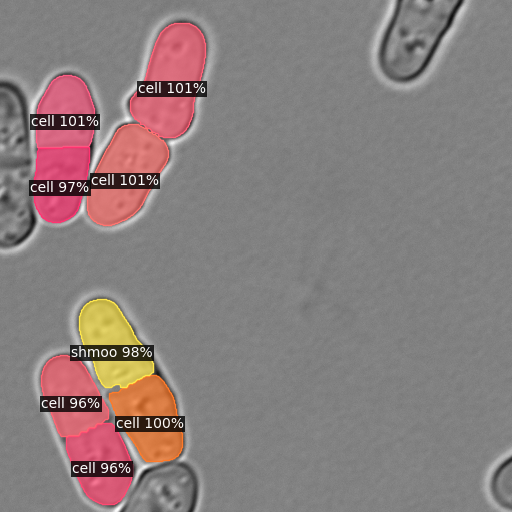

In [8]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [9]:
from post_process_utils import get_largest_object

In [15]:
panopitc_labels = instances.panoptic_label.to("cpu").numpy()
instances = prediction_output['instances']
pred_masks = instances.pred_masks.to("cpu").numpy()
scores = instances.scores
instance_scores = instances.center_scores
pred_classes = instances.pred_classes
processed = np.zeros(pred_masks[0].shape, dtype=np.uint16)

threshold = 0.1
ins_threshold = 0.8
area_threshold = 500

post_precessed_mask = np.zeros(pred_masks[0].shape, dtype=np.uint16)
for pred_mask, score, ins_score, label in zip(pred_masks, scores, instance_scores, panopitc_labels):
    if score < threshold:
        continue
    if ins_score < ins_threshold:
        continue
    if pred_mask[0,:].any() or pred_mask[-1, :].any():
        continue
    if pred_mask[:, 0].any() or pred_mask[:, -1].any():
        continue
    area = pred_mask.sum()
    if area < area_threshold:
        continue
    num, mask = get_largest_object(np.array(pred_mask))
    if num == 0:
        continue
    post_precessed_mask[mask] = label

In [16]:
import matplotlib.pyplot as plt

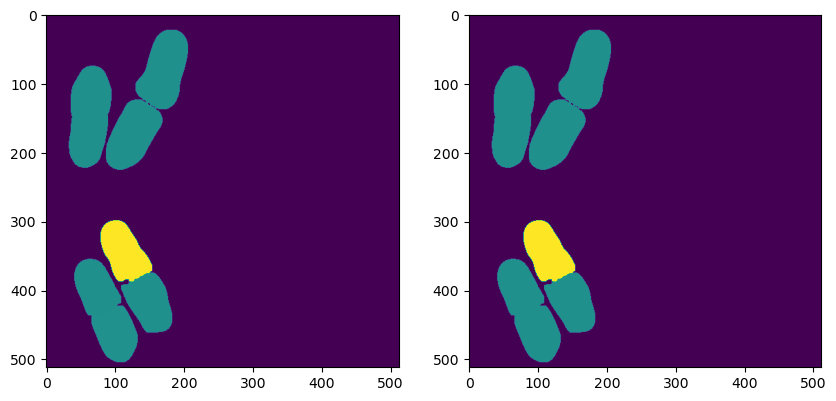

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(panoptic_seg)
axs[1].imshow(post_precessed_mask)

In [13]:
instances.panoptic_label
# predictor.model = predictor.model.half()

tensor([1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 2001], device='cuda:0')

['/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_0_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_1_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_2_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_3_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_2_rigid.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_2_rigid_crop_0_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partn

In [8]:
from skimage import measure, morphology

def single_region_process(mask, threshold=1000):
    """
    Given a binary mask (2D numpy array), returns:
    - count: number of connected components (objects)
    - largest_mask: binary mask of the largest object
    """
    labeled = measure.label(mask)  # Assigns a unique label to each connected region
    props = measure.regionprops(labeled)

    if not props:
        return 0, np.zeros_like(mask, dtype=bool)

    # Find region with largest area
    largest = max(props, key=lambda x: x.area)

    # Create a new mask for the largest region
    largest_mask = labeled == largest.label
    largest_mask = morphology.remove_small_holes(largest_mask, threshold)
    return len(props), largest_mask


def self_defined_post_process2(prediction_output):
    instances = predictions['instances']
    pred_masks = instances.pred_masks
    scores = instances.scores
    instance_scores = instances.center_scores
    pred_classes = instances.pred_classes
    processed = np.zeros(pred_masks[0].shape, dtype=np.uint16)
    for pred_mask, score, ins_score, label in zip(pred_masks, scores, instance_scores, pred_classes):
        if score < threshold:
            continue
        if ins_score < self_set_ins_threshold:
            continue
        if pred_mask[0,:].any() or pred_mask[-1, :].any():
            continue
        if pred_mask[:, 0].any() or pred_mask[:, -1].any():
            continue
        area = pred_mask.sum()
        if area < area_threshold:
            continue
        num, mask = get_largest_object(np.array(pred_mask))
        if num == 0:
            continue
        # processed[mask] = 
        

In [9]:
DIVISION = 1000
min_box = 0
max_box = 1300
crops = [[0, max_box ,0,max_box], [0, max_box ,2048-max_box,2048], [2048-max_box,2048,0,max_box], [2048-max_box,2048,2048-max_box,2048]]
score_threshold = 0.7

def self_defined_post_process(prediction_output):
    panoptic_seg, _ = prediction_output["panoptic_seg"]
    panoptic_seg[panoptic_seg<DIVISION] = 0
    panoptic_seg = panoptic_seg.cpu().numpy()
    panopitc_labels = np.unique(panoptic_seg)
    panopitc_labels = panopitc_labels[panopitc_labels>DIVISION]

    instances = prediction_output["instances"]
    scores = list(instances.center_scores.to("cpu"))
    bboxes = instances.pred_boxes.to("cpu")
    del instances

    segments_info= []
    if len(panopitc_labels) == len(scores):
        for in_x, panoptic_label in enumerate(panopitc_labels):
            a ,b, c, d = bboxes[in_x].tensor[0]
            if (a == min_box) | (b == min_box) | (c == max_box) | (d == max_box) | (scores[in_x] < score_threshold):
                panoptic_seg[panoptic_seg==panoptic_label] = 0
                continue

            segments_info.append(
                {
                    "id": int(panoptic_label),
                    "category_id": int(panoptic_label // DIVISION),
                    "isthing": True,
                    "score": float(scores[in_x]),
                }
            )
    return panoptic_seg, segments_info

In [10]:
movie = imread(movie_path_list[0])

In [11]:
movie_path_list

['/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_0_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_1_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_2_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_1_rigid_crop_3_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_2_rigid.tif',
 '/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_2_rigid_crop_0_mask.tif',
 '/home/liwa/data/mating_data/20260624_movies_partn

In [17]:
for movie_path in movie_path_list[2:]:
    print(movie_path)
    movie = imread(movie_path)
    for idx, (c1, c2, c3, c4) in enumerate(crops):
        cropped_movie = movie[:, c1:c2, c3:c4]
        segment_movie = np.zeros(cropped_movie.shape, dtype=np.uint16)
        segments_info_movie = []

        for frame in trange(0, cropped_movie.shape[0]):
            try:
                image = cropped_movie[frame,:,:]
                image = image - image.min()
                image = image / image.max()
                image = (image * 255).astype(np.uint8)
                im = np.stack((image,)*3, axis=-1)
                prediction_output = predictor(im)
                panoptic_seg, segments_info = self_defined_post_process(prediction_output)
                                                
                segment_movie[frame] = np.array(panoptic_seg,  dtype=np.uint16)
                segments_info_movie.append(segments_info)
                
                del prediction_output, panoptic_seg, segments_info, image, im
            except Exception as e:
                print("Error occurred:", e)
                continue

        imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
        with open(movie_path[:-4]+f"_crop_{idx}_segment_info.pkl", "wb") as f:
            pickle.dump(segments_info_movie, f)
        del cropped_movie, segment_movie, segments_info_movie
    del movie

/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20240126_jb840_skambucha_Skambucha_4_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [03:06<00:00,  1.41s/it]


/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20250627_HETEROTHALLIC_overtheweekendkambucha_16_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [03:19<00:00,  1.55s/it]


/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20250627_HOMOTHALLIC_overtheweekendkambucha_05_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [02:21<00:00,  1.10s/it]


/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20250627_HOMOTHALLIC_overtheweekendkambucha_08_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [02:51<00:00,  1.33s/it]


/home/liwa/data/mating_data/20260624_movies_partnerdistance_kambucha_wanlan/20250627_HOMOTHALLICovertheweekendkambucha_06_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [02:08<00:00,  1.01it/s]


## test

(512, 512, 3)


aaa
0
2
is thing append
2
is thing append
nnn
dict_keys(['sem_seg', 'center', 'offset', 'panoptic_seg', 'instances'])


/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{2001: {'id': 2001, 'category_id': 2, 'isthing': True, 'score': 0.9895973801612854}, 2002: {'id': 2002, 'category_id': 2, 'isthing': True, 'score': 1.0041053295135498}}


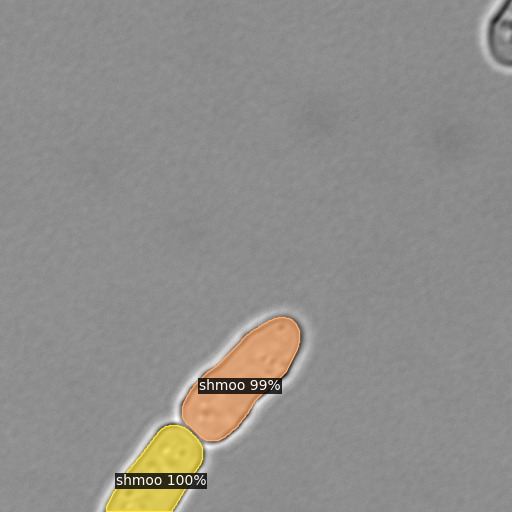

In [40]:
from skimage import measure, morphology

def single_region_process(mask, threshold=1000):
    """
    Given a binary mask (2D numpy array), returns:
    - count: number of connected components (objects)
    - largest_mask: binary mask of the largest object
    """
    labeled = measure.label(mask)  # Assigns a unique label to each connected region
    props = measure.regionprops(labeled)

    if not props:
        return 0, np.zeros_like(mask, dtype=bool)

    # Find region with largest area
    largest = max(props, key=lambda x: x.area)

    # Create a new mask for the largest region
    largest_mask = labeled == largest.label
    largest_mask = morphology.remove_small_holes(largest_mask, threshold)
    return len(props), largest_mask


def self_defined_post_process2(prediction_output):
    instances = predictions['instances']
    pred_masks = instances.pred_masks
    scores = instances.scores
    instance_scores = instances.center_scores
    pred_classes = instances.pred_classes
    processed = np.zeros(pred_masks[0].shape, dtype=np.uint16)
    for pred_mask, score, ins_score, label in zip(pred_masks, scores, instance_scores, pred_classes):
        if score < threshold:
            continue
        if ins_score < self_set_ins_threshold:
            continue
        if pred_mask[0,:].any() or pred_mask[-1, :].any():
            continue
        if pred_mask[:, 0].any() or pred_mask[:, -1].any():
            continue
        area = pred_mask.sum()
        if area < area_threshold:
            continue
        num, mask = get_largest_object(np.array(pred_mask))
        if num == 0:
            continue
        # processed[mask] = 
        

In [34]:
panoptic_seg, _ = prediction_output["panoptic_seg"]
panoptic_seg = panoptic_seg.to("cpu").numpy()
panopitc_labels = np.unique(panoptic_seg)[2:]

instances = prediction_output['instances']
pred_masks = instances.pred_masks.to("cpu").numpy()
scores = instances.scores
instance_scores = instances.center_scores
pred_classes = instances.pred_classes
processed = np.zeros(pred_masks[0].shape, dtype=np.uint16)

threshold = 0.5
ins_threshold = 0.8
area_threshold = 1000

post_precessed_mask = np.zeros(pred_masks[0].shape, dtype=np.uint16)
for pred_mask, score, ins_score, label in zip(pred_masks, scores, instance_scores, panopitc_labels):
    if score < threshold:
        continue
    if ins_score < ins_threshold:
        continue
    if pred_mask[0,:].any() or pred_mask[-1, :].any():
        continue
    if pred_mask[:, 0].any() or pred_mask[:, -1].any():
        continue
    area = pred_mask.sum()
    if area < area_threshold:
        continue
    num, mask = get_largest_object(np.array(pred_mask))
    if num == 0:
        continue
    post_precessed_mask[mask] = label

NameError: name 'get_largest_object' is not defined

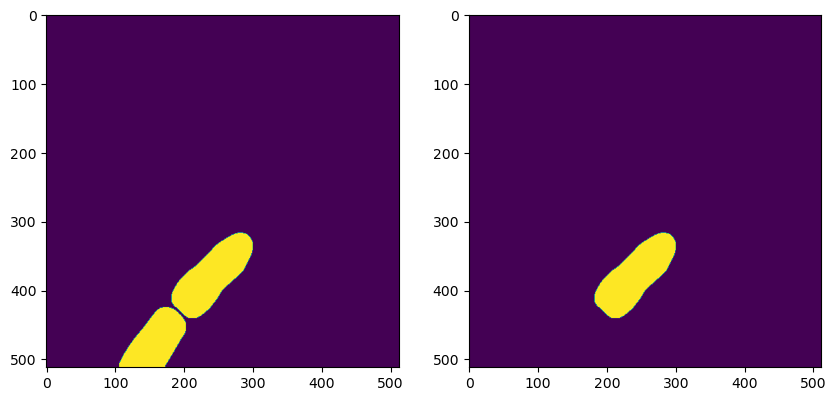

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(panoptic_seg)
ax[1].imshow(post_precessed_mask)

In [55]:
panopitc_labels

array([2001, 2002])

In [16]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg(panoptic_seg.to("cpu"), segments_info)

cv2_imshow(out.get_image()[:, :, ::-1])

NameError: name 'panoptic_seg' is not defined